In [106]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [107]:
max_seq_len = 120
embedding_dim = 300

PE shape is (120, 300)


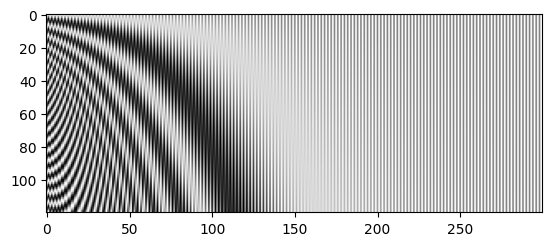

In [108]:
pe = np.array([
    [pos / 10000 ** (2.0 * (i // 2) / embedding_dim) for i in range(embedding_dim)]
 for pos in range(max_seq_len)])
print(f'PE shape is {pe.shape}')

pe[:, 0::2] = np.sin(pe[:, 0::2])
pe[:, 1::2] = np.cos(pe[:, 1::2])
pe_show = cv2.normalize(pe, None, 0, 1, cv2.NORM_MINMAX)
plt.imshow(pe_show, cmap='gray')

In [109]:
import torchtext.vocab as vocab
# cache_dir是保存golve词典的缓存路径
cache_dir = '.vector_cache/glove'
# dim是embedding的维度
glove = vocab.GloVe(name='6B', dim=embedding_dim, cache=cache_dir) 

sent = 'Apple and orange are all fruits'
word_embedding = glove.get_vecs_by_tokens(sent.split(), True).unsqueeze(0).numpy()

In [110]:
class Encoder:
    def __init__(self):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.embedding_dim = embedding_dim

    @staticmethod
    def ReLU(x):
        return x * (x > 0)

    @staticmethod
    def LayerNorm(x):
        """
        x.shape = (batch_size, length, dim)
        """
        mu = np.mean(x, axis=2, keepdims=True)
        std = np.std(x, axis=2, keepdims=True)

        return (x - mu) / std

    @staticmethod
    def Softmax(vec):
        return np.exp(vec) / np.sum(np.exp(vec))

    @staticmethod
    def add_and_norm(x):
        return x + Encoder.LayerNorm(x)

    def scaled_dot_product_attention(self, q, k, v):
        """
        q.shape = (batch_size, num_words, dim)
        """
        scale = np.sqrt(self.embedding_dim)
        attention = q @ k.swapaxes(1, 2) / scale
        attention = Encoder.Softmax(attention)

        context = np.matmul(attention, v)

        return context, attention

    def multihead_attention(self, q, k, v, heads=6):
        """
        q.shape = (batch_size, num_words, dim)
        """
        batch_size, num_words, _ = q.shape

        per_head_dim = self.embedding_dim // heads

        w_q = np.eye(self.embedding_dim)
        w_k = np.eye(self.embedding_dim)
        w_v = np.eye(self.embedding_dim)
        b_q = 0
        b_k = 0
        b_v = 0

        q = (q @ w_q + b_q).reshape(batch_size * heads, num_words, per_head_dim)
        k = (k @ w_k + b_k).reshape(batch_size * heads, num_words, per_head_dim)
        v = (v @ w_v + b_v).reshape(batch_size * heads, num_words, per_head_dim)

        context, attention = self.scaled_dot_product_attention(q, k, v)
        context = context.reshape(batch_size, num_words, per_head_dim * heads)
        attention = attention.reshape(batch_size, heads, num_words, num_words)

        w_c = np.eye(self.embedding_dim)
        b_c = 0

        context = context @ w_c + b_c

        return context, attention

    def fc(self, x):
        w_1 = np.eye(self.embedding_dim)
        b_1 = 0

        w_2 = np.eye(self.embedding_dim)
        b_2 = 0

        x = x @ w_1 + b_1
        x = Encoder.ReLU(x)
        x = x @ w_2 + b_2

        return x

    def encode(self, x):
        """
        x.shape = (batch_size, num_words, dim)
        """

        context, attention = self.multihead_attention(x, x, x)
        context = self.add_and_norm(context)
        context = self.fc(context)
        context = self.add_and_norm(context)

        return context, attention

In [111]:
print(word_embedding.shape)
encoder = Encoder()
context, attention = encoder.encode(word_embedding)
print(context.shape, attention.shape)

(1, 6, 300)
(1, 6, 300) (1, 6, 6, 6)


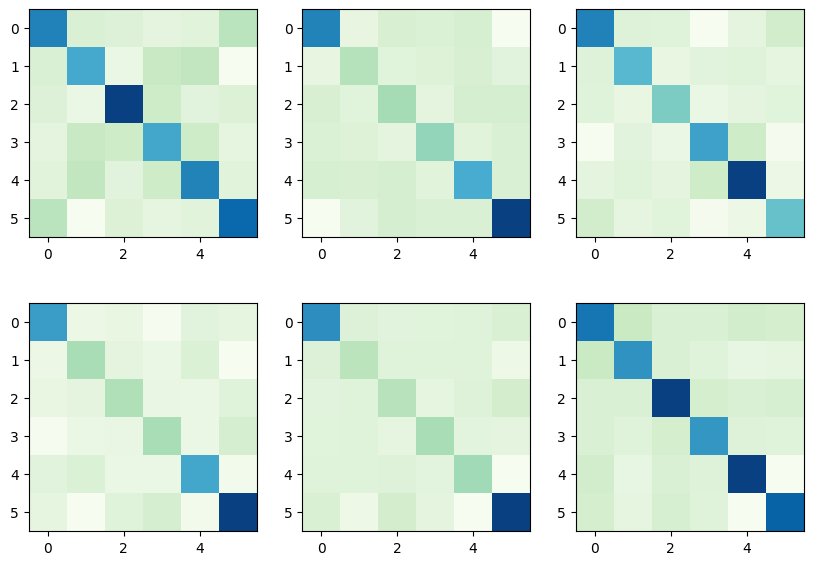

In [112]:
plt.figure(figsize=(10, 7))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(attention[0, i, :], cmap='GnBu')

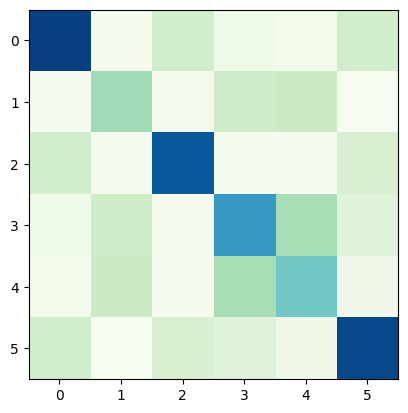

In [113]:
att = word_embedding @ word_embedding.swapaxes(1, 2)
plt.imshow(att[0, :], cmap='GnBu')